In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import matplotlib.patches
import matplotlib.lines
import matplotlib.colors
matplotlib.rcParams["figure.dpi"] = 150

import numpy as np

import sys
sys.path.append("..")
from encoder_learning_benchmarks.positive_definite_matrix import PositiveDefiniteMatrix
from encoder_learning_benchmarks.mahalanobis_distance import MahalanobisDistance

np.set_printoptions(precision=4, suppress=True)

In [169]:
def plot_gaussian(ax, mu, cov=None, theta=None, plot_cross=True, **kwargs):
    assert (cov is None) != (theta is None)
    if cov is None:
        cov_inv = PositiveDefiniteMatrix(len(mu), linlog=False)(theta)[0]
        cov = np.linalg.inv(cov_inv)
    Λ, V= np.linalg.eigh(cov)
    σ0 = np.sqrt(Λ[0])
    σ1 = np.sqrt(Λ[1])
    angle_rad = np.arctan2(V[1, 0], V[0, 0])
    angle = angle_rad / np.pi * 180.0

    ellipse = matplotlib.patches.Ellipse(np.copy(mu), 2.0 * σ0, 2.0 * σ1, angle, fill=False, **kwargs)
    ax.add_patch(ellipse)
    if "linewidth" in kwargs:
        kwargs["linewidth"] *= 0.5
    else:
        kwargs["linewidth"] = 0.75
    if plot_cross:
        ax.plot([mu[0] - σ0 * np.cos(angle_rad),
                 mu[0] + σ0 * np.cos(angle_rad)],
                [mu[1] - σ0 * np.sin(angle_rad),
                 mu[1] + σ0 * np.sin(angle_rad)], **kwargs)
        ax.plot([mu[0] + σ1 * np.sin(angle_rad),
                 mu[0] - σ1 * np.sin(angle_rad)],
                [mu[1] - σ1 * np.cos(angle_rad),
                 mu[1] + σ1 * np.cos(angle_rad)], **kwargs)

In [263]:
def measure_err(linlog=False, eta=1e-3, n_iter=1000, n_batch_size=1, plot=None, ax=None, seed=0, supervised=True):
    old_err = np.seterr(all="ignore")
    try:
        if (plot is None) and (not (ax is None)):
            plot = True

        np.random.seed(50123 + seed)

        # Create a random ground truth covariance matrix
        cov_ctor = PositiveDefiniteMatrix(2, linlog=False)
        theta_gt = np.random.randn(cov_ctor.n_params)
        mu_gt = np.random.randn(2)
        d_gt = MahalanobisDistance(cov_ctor.order, linlog=False)
        cov_gt_inv = cov_ctor(theta_gt)[0]
        cov_gt = np.linalg.inv(cov_gt_inv)

        if plot:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig, ax = ax.get_figure(), ax
            plot_gaussian(ax, mu_gt, cov_gt, linewidth=2, color='k', zorder=9, plot_cross=False)
            plot_gaussian(ax, mu_gt, cov_gt, linewidth=2, linestyle=(0, (1, 1)), color='k', zorder=11, plot_cross=False)
            ax.set_xlim(-5, 3)
            ax.set_ylim(-1.5, 4.5)
            ax.set_aspect(1)
            ax.set_xlabel("$x_1$")
            ax.set_ylabel("$x_2$")

        d = MahalanobisDistance(cov_ctor.order, linlog=linlog)
        mu, theta = np.zeros(d.n_dim), np.zeros(d.n_dim_theta)
        theta = np.zeros_like(theta_gt)
        mu_old = None
        errs = np.ones(n_iter) * np.nan
        ellipse_idcs = []
        for i in range(n_iter):
            # Pick the input samples
            x = np.random.multivariate_normal(mu_gt, cov_gt, n_batch_size)

            # Evaluate the learned distance measure at all samples
            #A = np.exp(-d(x, mu, theta))
            A = d(x, mu, theta)

            # Evaluate the ground-truth distance measure at the samples
            #A_gt = np.exp(-d_gt(x, mu_gt, theta_gt))
            A_gt = d_gt(x, mu_gt, theta_gt)

            # Compute the gradient at the samples
            _, dmu, dtheta = d.jacobian(x, mu, theta)
            #dmu = -dmu * A
            #dtheta = -dtheta * A

            # Perform gradient descent
            err = A - A_gt
            err_mu = err if supervised else A
            err_theta = err if supervised else (A - 4.0)
            mu -= eta * np.mean(err_mu * dmu[:, 0], axis=0)
            theta -= eta * np.mean(err * dtheta[:, 0], axis=0)
            errs[i] = np.mean(np.abs(err))

            if plot and ((mu_old is None) or (np.linalg.norm(mu_old - mu) > 0.5) or (i + 1 == n_iter)):
                c = cm.get_cmap('viridis')((i + 1) / n_iter)
                plot_gaussian(
                    ax, mu,
                    np.linalg.inv(cov_ctor(theta)[0]),
                    plot_cross=False,
                    linewidth=2,
                    color=c,
                    #color='b',
                    zorder=10)
                mu_old = np.copy(mu)
                ellipse_idcs.append((i, c))

        return (errs, ellipse_idcs) if plot else errs
    finally:
        np.seterr(**old_err)

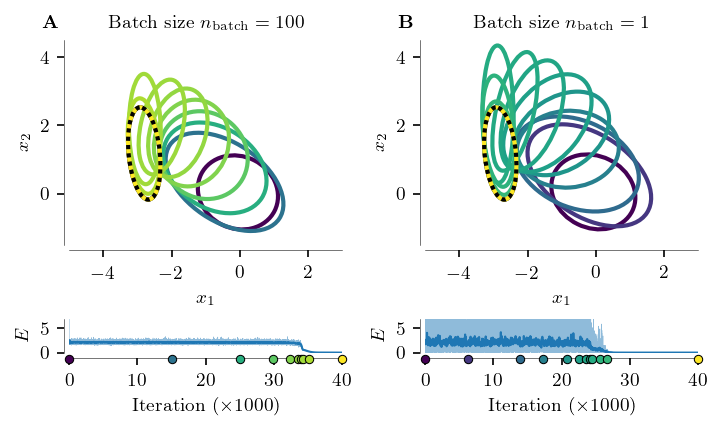

In [245]:
fig = plt.figure(constrained_layout=True, figsize=(4.7, 2.75))
spec = gridspec.GridSpec(ncols=2, nrows=5, figure=fig)
ax1A = fig.add_subplot(spec[0:4, 0])
ax2A = fig.add_subplot(spec[0:4, 1])
ax1B = fig.add_subplot(spec[4, 0])
ax2B = fig.add_subplot(spec[4, 1])

for ax, label in zip([ax1A, ax1B, ax2A, ax2B], ["A", "", "B", ""]):
    ax.text(-0.1, 1.125, "\\textbf{{{}}}".format(label),
            fontsize=9, transform=ax.transAxes,
            va="top", ha="left",
            bbox={"pad": 0.1, "linewidth": 0, "fc": 'white'})

def plot_errs(ax, n_iter, errs, eidcs=[], color=None):
    flt = np.exp(-np.square(np.linspace(-3, 3, 101)))
    flt /= np.sum(flt)

    if color is None:
        c = cm.get_cmap('tab10')(0.0)
    else:
        c = color
    c = matplotlib.colors.to_rgb(c)

    c1 = 0.5 * np.array(c) + 0.5
    c2 = np.array(c)    

    for idx, c in eidcs:
        ax.plot(idx / 1000, -1.25, 'o',
                color=c, clip_on=False,
                zorder=100, markersize=4,
                markeredgecolor='k',
                markeredgewidth=0.5)

    ax.plot(np.arange(1, n_iter + 1) / 1000, errs, color=c1, linewidth=0.25)
    ax.plot(np.arange(1, n_iter + 1) / 1000, np.convolve(errs, flt, 'same'), color=c2, linewidth=1)
    ax.set_xlim(0, n_iter / 1000)
    ax.set_ylim(0, 7)
    ax.set_xlabel('Iteration ($\\times 1000$)')
    ax.set_ylabel('$E$')

n_iter = 40000
errs, eidcs = measure_err(eta=1e-3, n_iter=n_iter, n_batch_size=100, seed=7489, ax=ax1A)
ax1A.set_title("Batch size $n_\\mathrm{batch}=100$")
plot_errs(ax1B, n_iter, errs, eidcs)

errs, eidcs = measure_err(eta=1e-3, n_iter=n_iter, n_batch_size=1, seed=7489, ax=ax2A)
ax2A.set_title("Batch size $n_\\mathrm{batch}=1$")
plot_errs(ax2B, n_iter, errs, eidcs)

for spine in ["top", "right"]:
    for ax in [ax1A, ax1B, ax2A, ax2B]:
        ax.spines[spine].set_visible(False)
        ax.spines[spine].set_visible(False)
for spine in ["left", "bottom"]:
    for ax in [ax1A, ax1B, ax2A, ax2B]:
        ax.spines[spine].set_position(("outward", 2.5))
        ax.spines[spine].set_position(("outward", 2.5))

fig.savefig("out/learn_distribution_example.pdf", transparent=True, bbox_inches='tight')

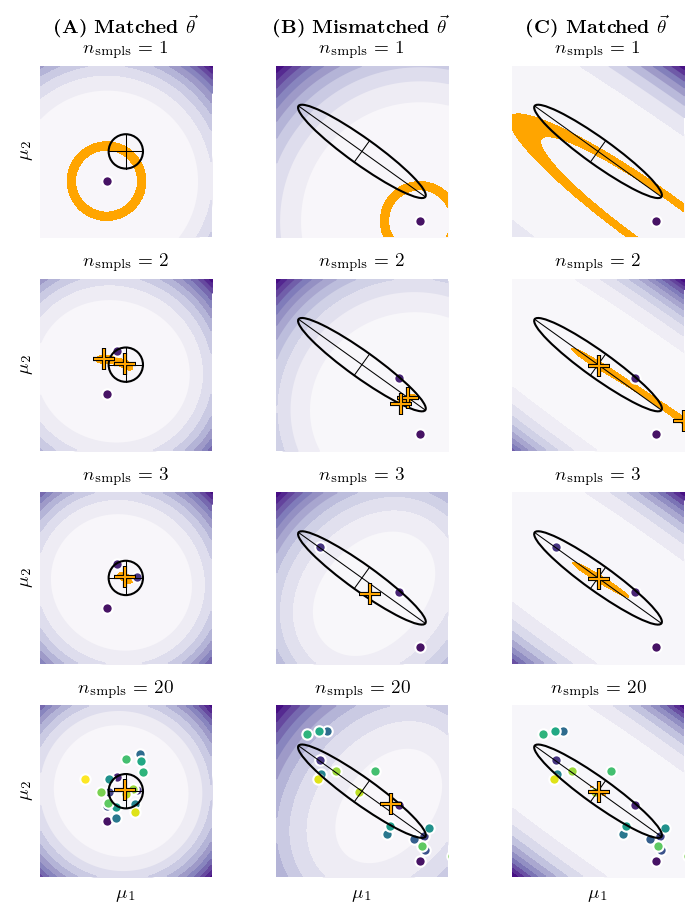

In [17]:
def error_landscape(x, theta, theta_gt, mu_gt, r=5):
    x = np.asarray(x, dtype=np.float)
    theta_gt = np.asarray(theta_gt, dtype=np.float)
    mu_gt = np.asarray(mu_gt, dtype=np.float)

    xs = np.linspace(-r, r, 100)
    ys = np.linspace(-r, r, 100)
    xss, yss = np.meshgrid(xs, ys)
    mus = np.array((xss.flatten(), yss.flatten())).T
    N = mus.shape[0]

    d = MahalanobisDistance(x.size, linlog=False)

    A = d(mus, x, theta)
    A_gt = d(mu_gt, x, theta_gt)

    zss = np.square(A - A_gt)

    return xs, ys, zss.reshape(xss.shape)

fig, axs = plt.subplots(4, 3, figsize=(4.7, 6.0), sharex=True, sharey=True, constrained_layout=True)

titles = [r"\textbf{(A) Matched $\vec \theta$}",
          r"\textbf{(B) Mismatched $\vec \theta$}",
          r"\textbf{(C) Matched $\vec \theta$}",]
for col in [0, 1, 2]:
    np.random.seed(78914)

    mu_gt = np.array([0, 0])
    zss = None
    row = 0
    pnts = []
    for i in range(100):
        if col == 0:
            theta_gt = [0, 0, 0]
        else:
            theta_gt = [-0.25, -1.0, 1]
        if col < 2:
            theta = np.zeros(3)
        else:
            theta = np.copy(theta_gt)
        cov_gt = np.linalg.inv(PositiveDefiniteMatrix(2, linlog=False)(theta_gt)[0])
        x = np.random.multivariate_normal(mu_gt, cov_gt)
        xs, ys, zss_new = error_landscape(x, theta, theta_gt, mu_gt)
        pnts.append(x)
        if zss is None:
            zss = zss_new
        else:
            zss += zss_new

        if i in [0, 1, 2, 19]:
            ax = axs[row, col]
            zmin = np.min(zss)
            zmax = np.max(zss)
            
            cnt = ax.contourf(xs, ys, zss, levels=11, cmap='Purples')
            for c in cnt.collections:
                c.set_edgecolor("face")
            ax.contourf(xs, ys, zss, colors=['orange'], levels=[zmin, zmin + 1.0])
            #ax.contour(xs, ys, zss, colors=['black'], levels=[zmin + 0.4], linestyles=[(0, (1, 1))], linewidths=[2])
            for i, x in enumerate(pnts):
                ax.plot(x[0], x[1], 'o', color=cm.get_cmap('viridis')((i + 1) / 20),  markersize=5, markeredgecolor='white')
            if row == 3:
                ax.set_xlabel("$\\mu_1$")
            if col == 0:
                ax.set_ylabel("$\\mu_2$")
            ax.set_aspect(1)
            ax.set_xlim(np.min(xs), np.max(xs))
            ax.set_ylim(np.min(ys), np.max(ys))
            ax.set_xticks([])
            ax.set_yticks([])
            #ax.set_xticks([-5, 0, 5])
            #ax.set_yticks([-5, 0, 5])
            #ax.set_yticklabels(["", "", ""])
            #ax.set_xticklabels(["", "", ""])
            #ax.set_xticks([-5, -2.5, 0, 2.5, 5])
            #ax.set_xticklabels(["-5", "", "0", "", "5"])
            #ax.set_yticks([-5, -2.5, 0, 2.5, 5])
            #ax.set_yticklabels(["-5", "", "0", "", "5"])

            # Ground-truth
            plot_gaussian(ax, mu_gt, theta=theta_gt, color='black', linewidth=1, zorder=10)

            zss_cpy = np.copy(zss)
            for j in range([0, 2, 1, 1][row]):
                zmin_idx = np.argmin(zss_cpy)
                zmin_idcs = np.unravel_index(zmin_idx, zss_cpy.shape)
                zmin_coords = (xs[zmin_idcs[1]], ys[zmin_idcs[0]])

                for ii in range(-2, 3):
                    for jj in range(-2, 3):
                        iii = zmin_idcs[0] + ii
                        jjj = zmin_idcs[0] + jj < ys.size
                        if (iii >= 0) and (iii < xs.size) and (jjj >= 0) and (jjj < ys.size):
                            zss_cpy[iii, jjj] = np.inf

                ax.plot(*zmin_coords, '+', color='k', markersize=11, markeredgewidth=2, zorder=11)
                ax.plot(*zmin_coords, '+', color='orange', markersize=10, markeredgewidth=1, zorder=11)

#            for spine in ["left", "bottom"]:
#                ax.spines[spine].set_position(('outward', 2))

            for spine in ["left", "bottom", "top", "right"]:
                ax.spines[spine].set_visible(False)

            if i == 0:
                ax.set_title(titles[col] + "\n" + r"$n_\mathrm{{smpls}} = {}$".format(i + 1))
            else:
                ax.set_title(r"$n_\mathrm{{smpls}} = {}$".format(i + 1))

            row += 1

fig.savefig('out/mahalanobis_distance_mu_bp.pdf', transparent=True, bbox_inches='tight')

In [291]:
n_iter, n_repeat, eta = 20000, 1000, 1e-3
tasks = [
    (i, 2 * (2 * j1 + j2) + j3, seed, n_batch_size, linlog, supervised)
    for i, seed in enumerate(range(n_repeat))
    for j1, n_batch_size in enumerate([100, 1])
    for j2, supervised in enumerate([True, False])
    for j3, linlog in enumerate([True, False])
]

def run_task(params):
    i, j, seed, n_batch_size, linlog, supervised = params
    errs = measure_err(linlog=linlog, eta=eta, n_iter=n_iter, n_batch_size=n_batch_size, seed=seed, supervised=supervised)
    return i, j, errs

import multiprocessing
import tqdm

errs = np.zeros((8, n_repeat, n_iter))
with multiprocessing.Pool(multiprocessing.cpu_count() // 2) as pool:
    for i, j, E in tqdm.tqdm(pool.imap(run_task, tasks), total=len(tasks)):
        errs[j, i] = E

100%|██████████| 8000/8000 [55:06<00:00,  2.42it/s]  


In [4]:
#np.save('out/mahalanobis_distance_gradient_descent_errs.npy', errs)

In [5]:
errs = np.load('out/mahalanobis_distance_gradient_descent_errs.npy')

In [6]:
errs_nb100_ll_sv,\
errs_nb100_sv, \
errs_nb100_ll_usv,\
errs_nb100_usv, \
errs_nb1_ll_sv,\
errs_nb1_sv, \
errs_nb1_ll_usv,\
errs_nb1_usv = errs

In [7]:
ndiv_nb100_ll_sv,\
ndiv_nb100_sv, \
ndiv_nb100_ll_usv,\
ndiv_nb100_usv, \
ndiv_nb1_ll_sv,\
ndiv_nb1_sv, \
ndiv_nb1_ll_usv,\
ndiv_nb1_usv = np.mean(np.isnan(errs), axis=1)

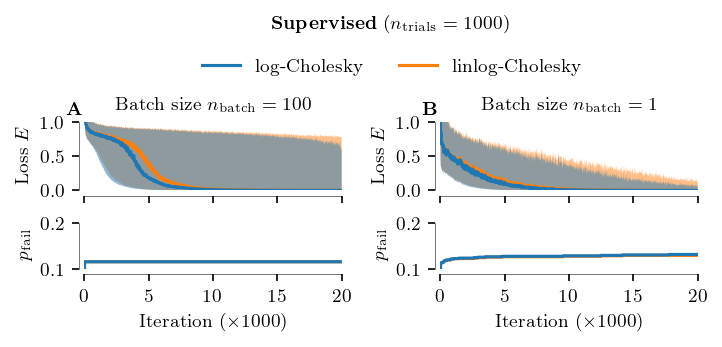

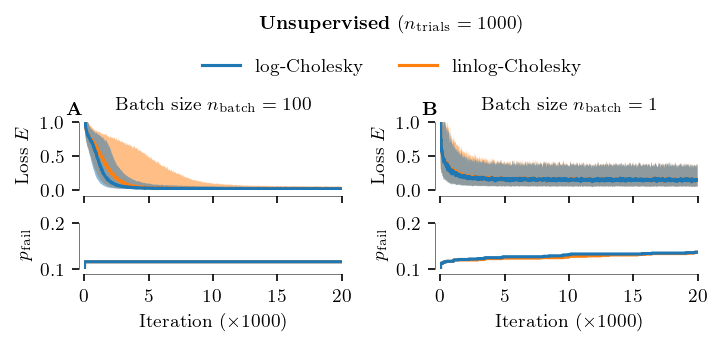

In [65]:
fig1 = plt.figure(constrained_layout=True, figsize=(4.7, 2.2))
fig2 = plt.figure(constrained_layout=True, figsize=(4.7, 2.2))
spec1 = gridspec.GridSpec(ncols=2, nrows=6, figure=fig1)
spec2 = gridspec.GridSpec(ncols=2, nrows=6, figure=fig2)
axs = np.array([
    [fig1.add_subplot(spec1[1:4, 0]), fig1.add_subplot(spec1[1:4, 1])],
    [fig1.add_subplot(spec1[4:6, 0]), fig1.add_subplot(spec1[4:6, 1])],
    [fig2.add_subplot(spec2[1:4, 0]), fig2.add_subplot(spec2[1:4, 1])],
    [fig2.add_subplot(spec2[4:6, 0]), fig2.add_subplot(spec2[4:6, 1])],
])
ax_legend1 = fig1.add_subplot(spec1[0, 0:2])
ax_legend2 = fig2.add_subplot(spec2[0, 0:2])

for ax, label in zip([axs[0, 0], axs[0, 1], axs[2, 0], axs[2, 1]], ["A", "B", "A", "B"]):
    ax.text(-0.07, 1.3, "\\textbf{{{}}}".format(label),
            fontsize=9, transform=ax.transAxes,
            va="top", ha="left",
            bbox={"pad": 0.1, "linewidth": 0, "fc": 'white'})

def plot_errs(ax, errs, color='k', ss=20, **kwargs):
    n_iter = errs.shape[1]
    iters = np.arange(1, n_iter + 1)
    p25 = np.nanpercentile(errs[:, ::ss], 25, axis=0)
    p50 = np.nanpercentile(errs[:, ::ss], 50, axis=0)
    p75 = np.nanpercentile(errs[:, ::ss], 75, axis=0)

    c = np.asarray(matplotlib.colors.to_rgb(color))
    c1 = c * 0.5 + 0.5
    c2 = np.copy(c)

    ax.fill_between(iters[::ss] / 1000, p25, p75, color=c2, alpha=0.5, linewidth=0)
    ax.plot(iters[::ss] / 1000, p50, color=c2, **kwargs)
    ax.set_ylim(0, 1)
    ax.set_xlim(0, n_iter / 1000)
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_ylabel('Loss $E$')

def plot_ndiv(ax, ndiv, color='k', ss=20, **kwargs):
    n_iter = ndiv.shape[0]
    iters = np.arange(1, n_iter + 1)

    c = np.asarray(matplotlib.colors.to_rgb(color))
    ax.plot(iters[::ss] / 1000, ndiv[::ss] * 100, color=c, **kwargs)
    ax.set_ylim(10, 20)
    ax.set_xlim(0, n_iter / 1000)
    ax.set_yticks([10, 20])
    ax.set_yticklabels(["0.1", "0.2"])
    ax.set_ylabel('$p_\\mathrm{fail}$')
    ax.set_xlabel('Iteration ($\\times 1000$)')

def plot_set(ax_errs, ax_ndiv, errs, ndiv, **kwargs):
    plot_errs(ax_errs, errs, **kwargs)
    plot_ndiv(ax_ndiv, ndiv, **kwargs)

def mklegend(ax, colors, labels):
    ax.set_frame_on(False)
    ax.set_xticks([])
    ax.set_yticks([])

    artists = [matplotlib.lines.Line2D([0], [0], color=c) for c in colors]
    ax.legend(artists, labels, ncol=len(labels), loc='upper center')

c1 = cm.get_cmap('tab10')(0.0)
c2 = cm.get_cmap('tab10')(0.1)

axs[0, 0].set_title("Batch size $n_\\mathrm{batch} = 100$")
axs[0, 1].set_title("Batch size $n_\\mathrm{batch} = 1$")
axs[2, 0].set_title("Batch size $n_\\mathrm{batch} = 100$")
axs[2, 1].set_title("Batch size $n_\\mathrm{batch} = 1$")

plot_set(axs[0, 0], axs[1, 0], errs_nb100_ll_sv, ndiv_nb100_ll_sv, color=c2)
plot_set(axs[0, 0], axs[1, 0], errs_nb100_sv, ndiv_nb100_sv, color=c1)
plot_set(axs[0, 1], axs[1, 1], errs_nb1_ll_sv, ndiv_nb1_ll_sv, color=c2)
plot_set(axs[0, 1], axs[1, 1], errs_nb1_sv, ndiv_nb1_sv, color=c1)

plot_set(axs[2, 0], axs[3, 0], errs_nb100_ll_usv, ndiv_nb100_ll_usv, color=c2)
plot_set(axs[2, 0], axs[3, 0], errs_nb100_usv, ndiv_nb100_usv, color=c1)
plot_set(axs[2, 1], axs[3, 1], errs_nb1_ll_usv, ndiv_nb1_ll_usv, color=c2)
plot_set(axs[2, 1], axs[3, 1], errs_nb1_usv, ndiv_nb1_usv, color=c1)

mklegend(ax_legend1, [c1, c2], ['$\\mathrm{log}$-Cholesky', '$\\mathrm{linlog}$-Cholesky'])
ax_legend1.set_title('\\textbf{Supervised} ($n_\\mathrm{trials} = 1000$)')

mklegend(ax_legend2, [c1, c2], ['$\\mathrm{log}$-Cholesky', '$\\mathrm{linlog}$-Cholesky'])
ax_legend2.set_title('\\textbf{Unsupervised} ($n_\\mathrm{trials} = 1000$)')

for i in [0, 2]:
    for j in [0, 1]:
        axs[i, j].set_xticklabels([])
for spine in ["top", "right"]:
    for ax in axs.flat:
        ax.spines[spine].set_visible(False)
for spine in ["left", "bottom"]:
    for ax in axs.flat:
        ax.spines[spine].set_position(("outward", 2.5))
        ax.spines[spine].set_position(("outward", 2.5))

fig1.savefig('out/learn_distribution_supervised.pdf', transparent=True, bbox_inches='tight')
fig2.savefig('out/learn_distribution_unsupervised.pdf', transparent=True, bbox_inches='tight')